In [1]:
from post_processing import Analysis

In [2]:
analysis = Analysis("diags202312181612")

/scinet/niagara/software/2019b/opt/base/python/3.11.5/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


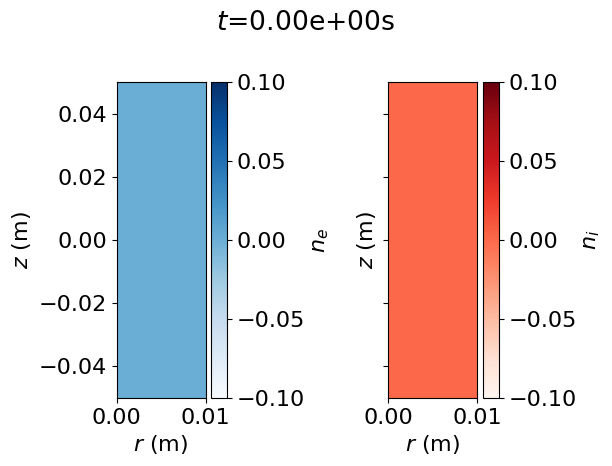

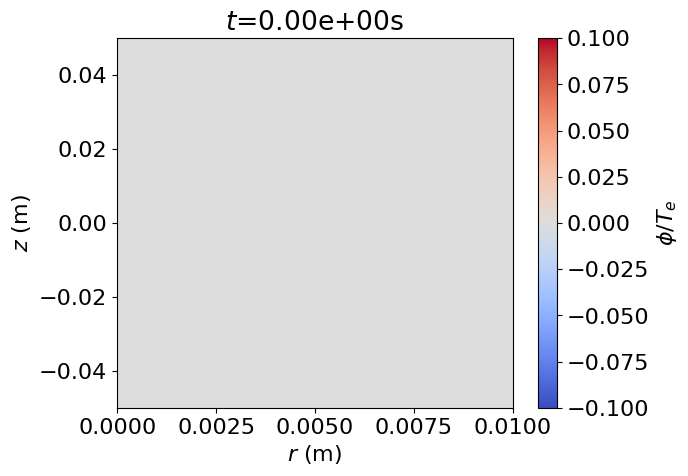

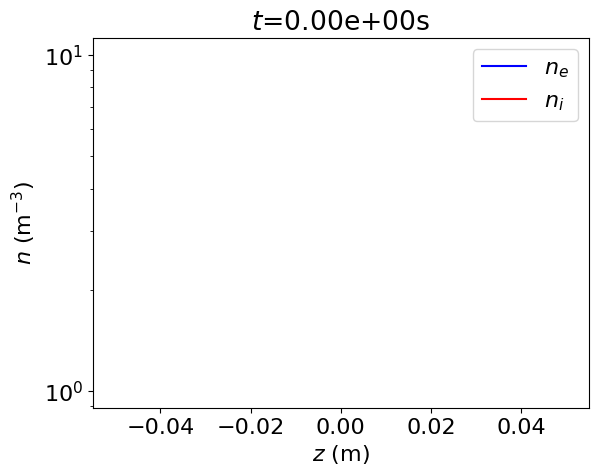

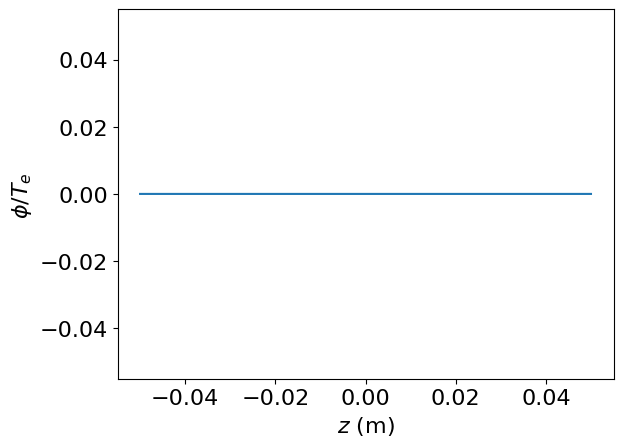

In [3]:
frame = 0
for plot_type in ["slice", "line"]:
    analysis.plot_density(frame, plot_type=plot_type)
    analysis.plot_potential(frame, plot_type=plot_type)

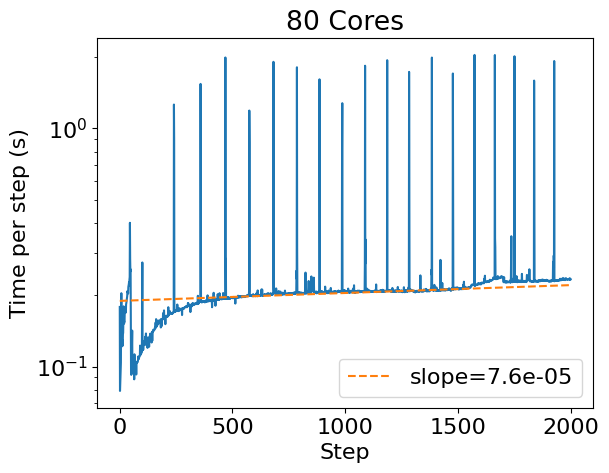

Slope is small, consider time per step as constant. 
Using linear fitting.


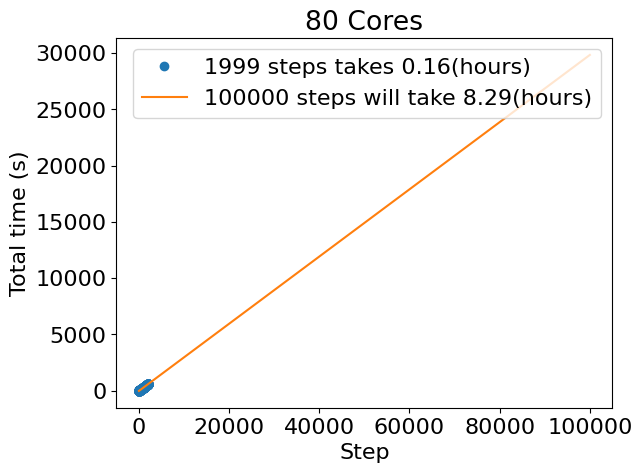

In [4]:
analysis.plot_time(100000)